In [97]:
import pandas as pd
import os

# File path
file_path = os.path.join("./", "superstore_train.csv")

# Load the dataset with encoding fix
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Fix data types
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

categorical_cols = ['Category', 'Sub-Category', 'Segment', 'Region', 'Ship Mode', 'City', 'State', 'Country']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Quick preview
print(df.dtypes)
df.head()


Row ID                         int64
Order ID                      object
Order Date            datetime64[ns]
Ship Date             datetime64[ns]
Ship Mode                   category
Customer ID                   object
Customer Name                 object
Segment                     category
Country                     category
City                        category
State                       category
Postal Code                    int64
Region                      category
Product ID                    object
Category                    category
Sub-Category                category
Product Name                  object
Sales                        float64
Quantity                       int64
Discount                     float64
Profit                       float64
Shipping Delay                 int64
Discount Binned               object
Discounted Revenue           float64
Profit Margin                float64
dtype: object


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Delay,Discount Binned,Discounted Revenue,Profit Margin
0,4101,US-2017-102288,2017-06-19,2017-06-23,Standard Class,ZC-21910,Zuschuss Carroll,Consumer,United States,Houston,...,Appliances,Holmes Visible Mist Ultrasonic Humidifier with...,2.264,1,0.8,-5.2072,4,41-100%,0.4528,-2.300
1,2587,CA-2017-131695,2017-06-30,2017-07-06,Standard Class,RA-19285,Ralph Arnett,Consumer,United States,New York City,...,Storage,Steel Personal Filing/Posting Tote,248.570,7,0.0,67.1139,6,No Discount,248.5700,0.270
2,9195,CA-2014-146843,2014-11-30,2014-12-06,Standard Class,PB-19150,Philip Brown,Consumer,United States,Avondale,...,Supplies,Acme Office Executive Series Stainless Steel T...,47.992,7,0.2,3.5994,6,11-20%,38.3936,0.075
3,2003,CA-2017-163510,2017-12-25,2017-12-28,Second Class,JW-15955,Joni Wasserman,Consumer,United States,Louisville,...,Storage,Fellowes Bankers Box Stor/Drawer Steel Plus,95.940,3,0.0,9.5940,3,No Discount,95.9400,0.100
4,7226,CA-2016-109953,2016-07-14,2016-07-18,Standard Class,RB-19360,Raymond Buch,Consumer,United States,San Francisco,...,Furnishings,Deflect-O Glasstique Clear Desk Accessories,30.800,4,0.0,10.1640,4,No Discount,30.8000,0.330


In [98]:
# Drop identifier and non-predictive columns
columns_to_drop = [
    'Row ID', 
    'Order ID', 
    'Customer ID', 
    'Customer Name', 
    'Product ID', 
    'Product Name'
]

# Drop Country only if it has a single unique value
if df['Country'].nunique() == 1:
    columns_to_drop.append('Country')

df.drop(columns=columns_to_drop, inplace=True)

# Confirm the drop
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'City', 'State',
       'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Discounted Revenue', 'Profit Margin'],
      dtype='object')


In [99]:
import holidays
from datetime import timedelta

# Step 1: Extract time-based features
df['Order Month'] = df['Order Date'].dt.month_name().astype('category')
df['Order Quarter'] = df['Order Date'].dt.quarter.astype('category')
df['Order DayOfWeek'] = df['Order Date'].dt.day_name().astype('category')
df['Order Year'] = df['Order Date'].dt.year.astype('category')

# Step 2: Create custom list of discount-relevant US holidays
years = [2014, 2015, 2016, 2017]
us_holidays = holidays.US(years=years)

# Start with standard holidays relevant to retail
important_holidays = []

for date, name in us_holidays.items():
    if name in [
        "New Year's Day",
        "Presidents' Day",
        "Memorial Day",
        "Independence Day",
        "Labor Day",
        "Thanksgiving",
        "Christmas Day"
    ]:
        important_holidays.append(date)

# Add manually relevant retail dates
for y in years:
    important_holidays.append(pd.Timestamp(f"{y}-12-24"))  # Christmas Eve
    important_holidays.append(pd.Timestamp(f"{y}-12-31"))  # New Year's Eve

# Add Black Friday & Cyber Monday (based on Thanksgiving)
for date, name in us_holidays.items():
    if name == "Thanksgiving":
        black_friday = date + timedelta(days=1)
        cyber_monday = date + timedelta(days=4)
        important_holidays.extend([black_friday, cyber_monday])

# Step 3: Create holiday flag
important_holidays_str = set([d.strftime('%Y-%m-%d') for d in important_holidays])

df['Is Holiday Week'] = df['Order Date'].dt.strftime('%Y-%m-%d').isin(important_holidays_str)
df['Is Holiday Week'] = df['Is Holiday Week'].map({True: 'Yes', False: 'No'}).astype('category')

# Step 4: Drop raw date columns
df.drop(['Order Date', 'Ship Date'], axis=1, inplace=True)

# Step 5: Confirm result
print(df[['Order Month', 'Order DayOfWeek', 'Order Year', 'Is Holiday Week']].head())


  Order Month Order DayOfWeek Order Year Is Holiday Week
0        June          Monday       2017              No
1        June          Friday       2017              No
2    November          Sunday       2014              No
3    December          Monday       2017             Yes
4        July        Thursday       2016              No


In [100]:
# Define new file name and path
output_file = os.path.join("./", "superstore_modified_before_encoding.csv")

# Save to CSV (without the index column)
df.to_csv(output_file, index=False)

print(f"Modified dataset saved to: {output_file}")


Modified dataset saved to: ./superstore_modified_before_encoding.csv


In [101]:
df.dtypes
df.select_dtypes(include='category').columns.tolist()
for col in df.select_dtypes(include='category').columns:
    print(f"\n{col} — {df[col].nunique()} unique values")
    print(df[col].value_counts().head(10))



Ship Mode — 4 unique values
Ship Mode
Standard Class    4796
Second Class      1542
First Class       1225
Same Day           432
Name: count, dtype: int64

Segment — 3 unique values
Segment
Consumer       4170
Corporate      2427
Home Office    1398
Name: count, dtype: int64

City — 515 unique values
City
New York City    723
Los Angeles      594
Philadelphia     439
San Francisco    410
Seattle          355
Houston          299
Chicago          252
Columbus         172
San Diego        132
Springfield      132
Name: count, dtype: int64

State — 49 unique values
State
California        1579
New York           891
Texas              790
Pennsylvania       481
Washington         421
Illinois           402
Ohio               375
Florida            292
Michigan           203
North Carolina     193
Name: count, dtype: int64

Region — 4 unique values
Region
West       2554
East       2283
Central    1867
South      1291
Name: count, dtype: int64

Category — 3 unique values
Category
Office 

In [102]:
# Drop high-cardinality and overly granular columns and Is Holiday Week
df.drop(columns=['City', 'State', 'Sub-Category', 'Postal Code','Is Holiday Week'], inplace=True)

# Confirm drop
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Ship Mode', 'Segment', 'Region', 'Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Discounted Revenue', 'Profit Margin', 'Order Month', 'Order Quarter',
       'Order DayOfWeek', 'Order Year'],
      dtype='object')


In [103]:
missing = df.isnull().sum()
print(missing[missing > 0])

Series([], dtype: int64)


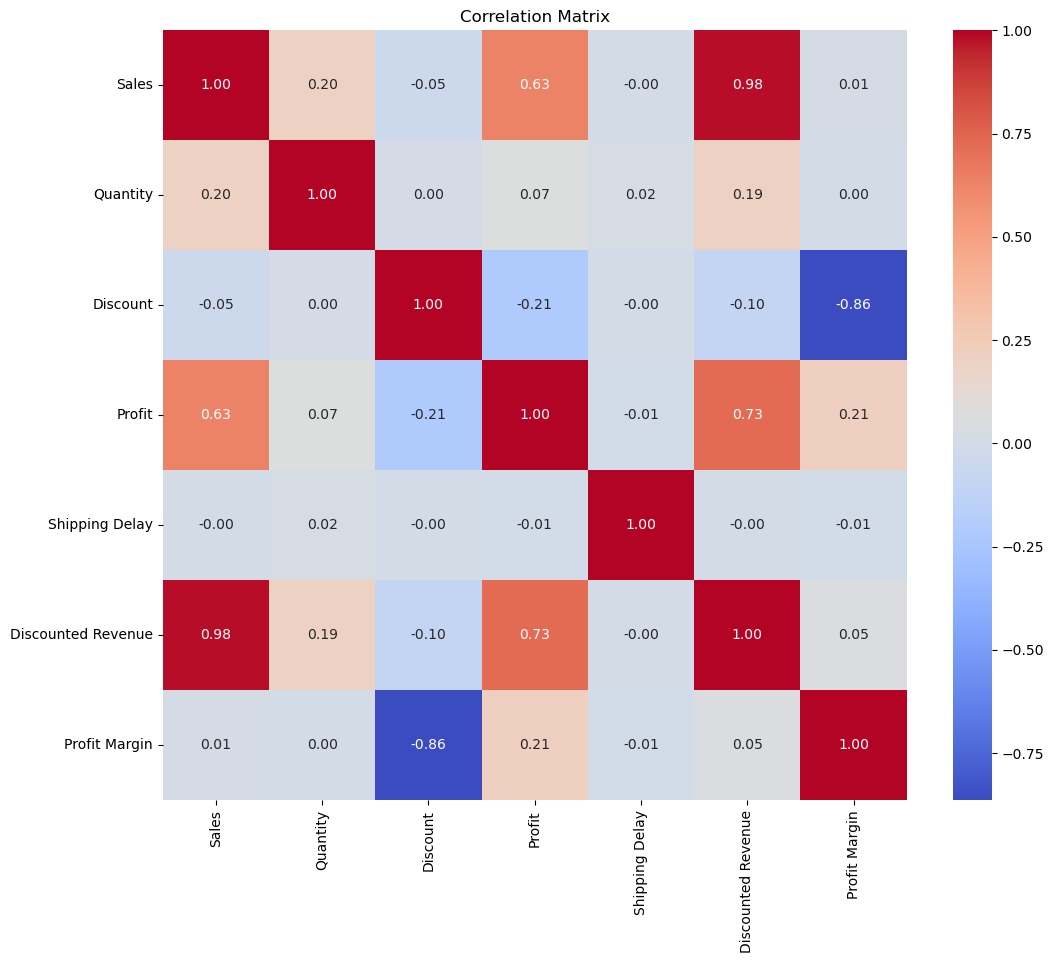

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


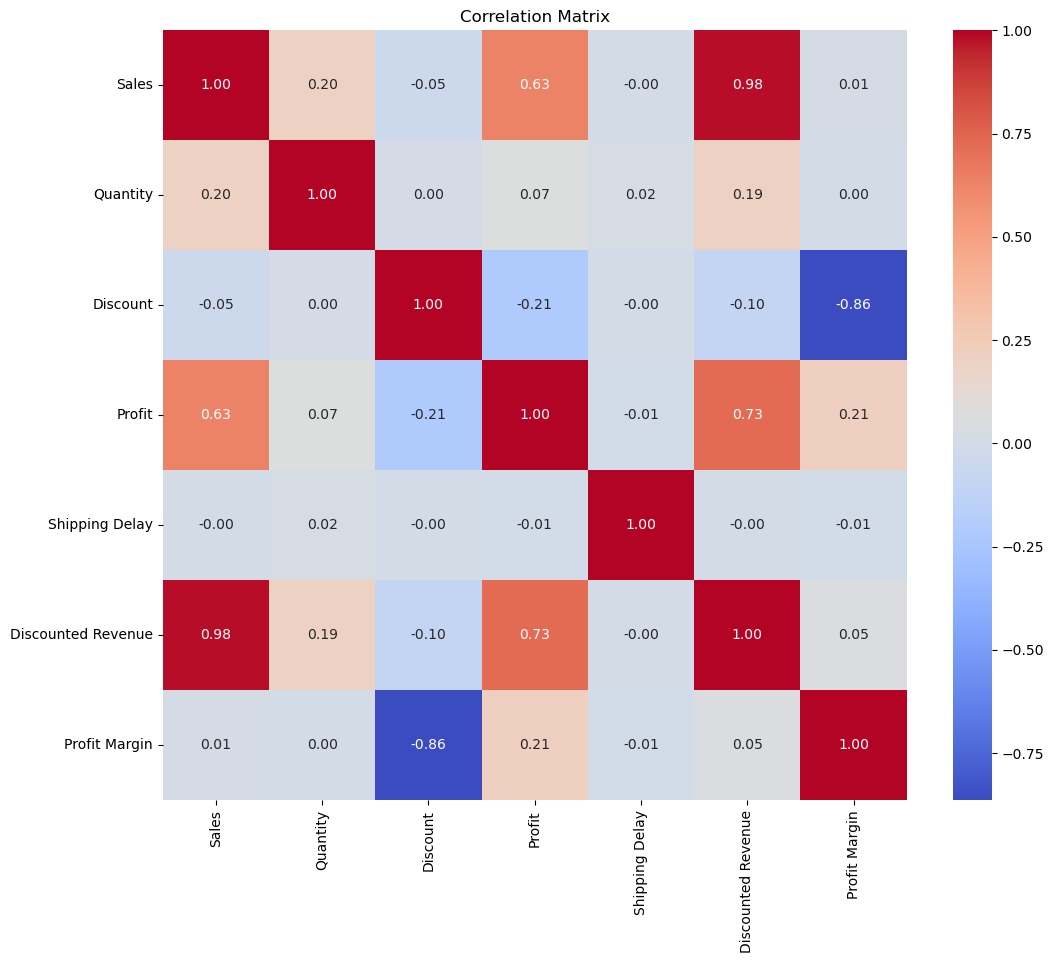


Highly Correlated Pairs (|r| > 0.8):
   Variable 1          Variable 2  Correlation
5       Sales  Discounted Revenue     0.983751
20   Discount       Profit Margin     0.864186


In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute correlation matrix (numerical columns only)
corr_matrix = df.corr(numeric_only=True)

# Step 2: Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Step 3: Extract pairs with correlation > 0.8 (and not 1.0)
# Stack the matrix, reset index, and rename columns
high_corr = corr_matrix.abs().stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Remove self-pairs and keep only one direction
high_corr = high_corr[high_corr['Variable 1'] != high_corr['Variable 2']]
high_corr = high_corr[high_corr['Correlation'] > 0.8]

# Drop duplicate pairs (A-B vs B-A)
high_corr['Pair'] = high_corr.apply(lambda row: tuple(sorted([row['Variable 1'], row['Variable 2']])), axis=1)
high_corr = high_corr.drop_duplicates(subset='Pair').drop(columns='Pair')

# Sort and display
high_corr = high_corr.sort_values(by='Correlation', ascending=False)
print("\nHighly Correlated Pairs (|r| > 0.8):")
print(high_corr)


In [106]:
# Drop derived/redundant columns
df.drop(columns=['Discounted Revenue', 'Profit Margin'], inplace=True)

# Confirm
print("Remaining columns:")
print(df.columns)


Remaining columns:
Index(['Ship Mode', 'Segment', 'Region', 'Category', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Shipping Delay', 'Discount Binned',
       'Order Month', 'Order Quarter', 'Order DayOfWeek', 'Order Year'],
      dtype='object')


In [107]:
# Step 0: Convert any object/bool columns meant for encoding to category
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'bool':
        df[col] = df[col].astype('category')

# Step 1: Identify categorical columns again
categorical_cols = df.select_dtypes(include='category').columns.tolist()

# Show their data types and unique value counts
for col in categorical_cols:
    print(f"\n🔍 {col} — {df[col].dtype} — {df[col].nunique()} unique values")
    print(df[col].unique())

# Step 2: One-hot encode with forced integer output (VIF-safe)
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# Step 3: Confirm final result
print(f"Shape after encoding: {df.shape}")
print("Column types after encoding:")
print(df.dtypes.value_counts())



🔍 Ship Mode — category — 4 unique values
['Standard Class', 'Second Class', 'First Class', 'Same Day']
Categories (4, object): ['First Class', 'Same Day', 'Second Class', 'Standard Class']

🔍 Segment — category — 3 unique values
['Consumer', 'Corporate', 'Home Office']
Categories (3, object): ['Consumer', 'Corporate', 'Home Office']

🔍 Region — category — 4 unique values
['Central', 'East', 'West', 'South']
Categories (4, object): ['Central', 'East', 'South', 'West']

🔍 Category — category — 3 unique values
['Office Supplies', 'Furniture', 'Technology']
Categories (3, object): ['Furniture', 'Office Supplies', 'Technology']

🔍 Discount Binned — category — 6 unique values
['41-100%', 'No Discount', '11-20%', '31-40%', '21-30%', '0-10%']
Categories (6, object): ['0-10%', '11-20%', '21-30%', '31-40%', '41-100%', 'No Discount']

🔍 Order Month — category — 12 unique values
['June', 'November', 'December', 'July', 'September', ..., 'October', 'May', 'August', 'January', 'February']
Length: 1

In [108]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop the target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add a constant for the intercept
X = add_constant(X)

# Step 3: Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Round and sort VIF values
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Variance Inflation Factors (VIF):")
print(vif_data)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🔍 Variance Inflation Factors (VIF):
                        Feature    VIF
21         Order Month_December    inf
30        Order Month_September    inf
22         Order Month_February    inf
20           Order Month_August    inf
26            Order Month_March    inf
24             Order Month_July    inf
28         Order Month_November    inf
29          Order Month_October    inf
23          Order Month_January    inf
31              Order Quarter_2    inf
32              Order Quarter_3    inf
33              Order Quarter_4    inf
3                      Discount  60.19
18      Discount Binned_41-100%  51.25
19  Discount Binned_No Discount  31.89
15       Discount Binned_11-20%  28.34
17       Discount Binned_31-40%   6.10
16       Discount Binned_21-30%   4.51
7      Ship Mode_Standard Class   3.97
4                Shipping Delay   3.16
6        Ship Mode_Second Class   2.01
27              Order Month_May   2.00
25             Order Month_June   1.95
13     Category_Office Suppl

In [109]:
# Drop one-hot encoded Order Quarter columns
quarter_cols = [col for col in df.columns if col.startswith('Order Quarter_')]
df.drop(columns=quarter_cols, inplace=True)

# Confirm drop
print("Dropped columns:", quarter_cols)


Dropped columns: ['Order Quarter_2', 'Order Quarter_3', 'Order Quarter_4']


In [110]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add constant
X = add_constant(X)

# Step 3: Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Clean output
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Updated VIF after dropping Order Quarter:")
print(vif_data)


🔍 Updated VIF after dropping Order Quarter:
                        Feature     VIF
0                         const  162.59
3                      Discount   60.19
18      Discount Binned_41-100%   51.25
19  Discount Binned_No Discount   31.89
15       Discount Binned_11-20%   28.34
17       Discount Binned_31-40%    6.10
16       Discount Binned_21-30%    4.51
7      Ship Mode_Standard Class    3.97
4                Shipping Delay    3.16
28         Order Month_November    2.77
21         Order Month_December    2.74
30        Order Month_September    2.71
29          Order Month_October    2.08
6        Ship Mode_Second Class    2.01
27              Order Month_May    2.00
24             Order Month_July    1.96
25             Order Month_June    1.95
26            Order Month_March    1.94
20           Order Month_August    1.94
13     Category_Office Supplies    1.93
39              Order Year_2017    1.88
38              Order Year_2016    1.80
12                  Region_West    1

In [111]:
# Drop all Discount Binned dummy variables
discount_bin_cols = [col for col in df.columns if col.startswith('Discount Binned_')]
df.drop(columns=discount_bin_cols, inplace=True)

# Confirm
print("Dropped columns:", discount_bin_cols)


Dropped columns: ['Discount Binned_11-20%', 'Discount Binned_21-30%', 'Discount Binned_31-40%', 'Discount Binned_41-100%', 'Discount Binned_No Discount']


In [112]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Step 1: Drop target variable (Profit)
X = df.drop(columns=['Profit'])

# Step 2: Add constant
X = add_constant(X)

# Step 3: Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Step 4: Clean output
vif_data['VIF'] = vif_data['VIF'].round(2)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Step 5: Display
print("🔍 Updated VIF after dropping Order Quarter:")
print(vif_data)


🔍 Updated VIF after dropping Order Quarter:
                      Feature    VIF
0                       const  48.79
7    Ship Mode_Standard Class   3.97
4              Shipping Delay   3.16
23       Order Month_November   2.77
16       Order Month_December   2.73
25      Order Month_September   2.71
24        Order Month_October   2.08
6      Ship Mode_Second Class   2.01
22            Order Month_May   2.00
20           Order Month_June   1.95
19           Order Month_July   1.95
15         Order Month_August   1.94
21          Order Month_March   1.94
34            Order Year_2017   1.88
33            Order Year_2016   1.80
12                Region_West   1.72
32            Order Year_2015   1.71
26     Order DayOfWeek_Monday   1.66
10                Region_East   1.65
28     Order DayOfWeek_Sunday   1.64
27   Order DayOfWeek_Saturday   1.61
29   Order DayOfWeek_Thursday   1.58
13   Category_Office Supplies   1.57
14        Category_Technology   1.54
5          Ship Mode_Same Day  

In [113]:
import statsmodels.api as sm

# Step 1: Define target and features
y = df['Profit']
X = df.drop(columns=['Profit'])

# Step 2: Add constant for intercept
X = sm.add_constant(X)

# Step 3: Fit the OLS model
model = sm.OLS(y, X).fit()

# Step 4: View model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:04:26   Log-Likelihood:                -52710.
No. Observations:                7995   AIC:                         1.055e+05
Df Residuals:                    7960   BIC:                         1.057e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

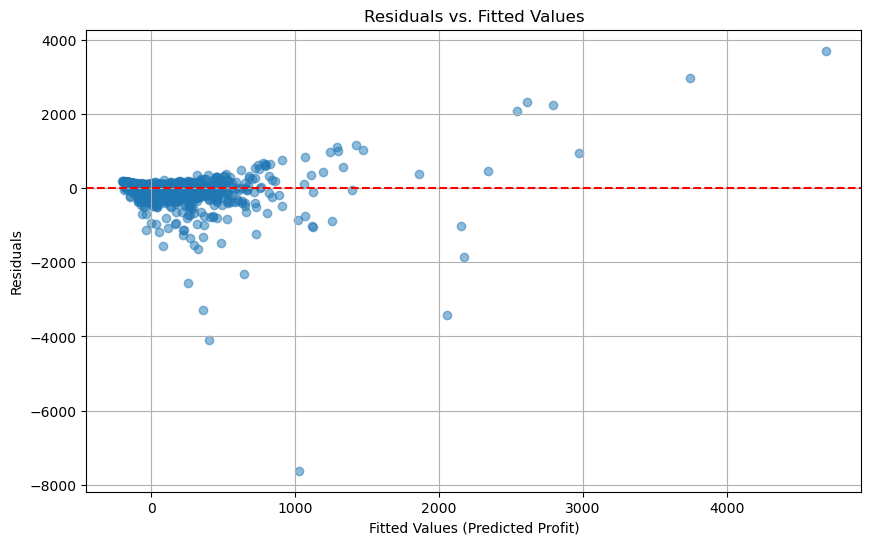

In [114]:
import matplotlib.pyplot as plt

# Get residuals and fitted values
fitted_vals = model.fittedvalues
residuals = model.resid

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predicted Profit)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.grid(True)
plt.show()


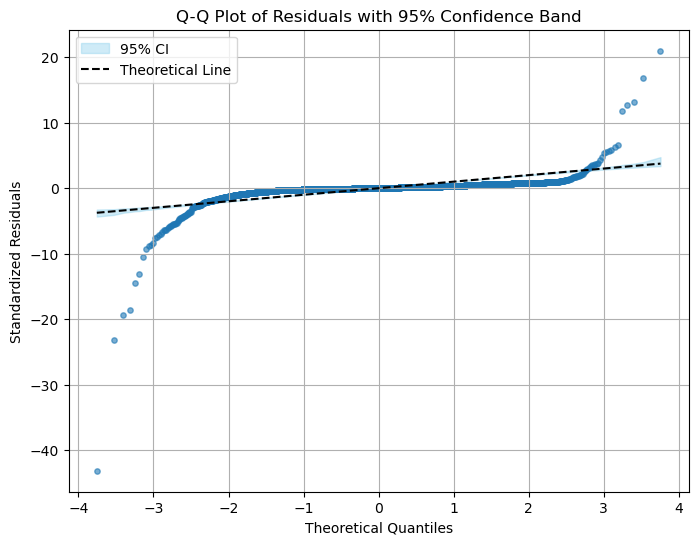

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Normalize residuals
residuals = model.resid
residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Get theoretical quantiles and ordered residuals
theoretical_q, sample_q = stats.probplot(residuals, dist="norm")

# Bootstrap for envelope
n = len(residuals)
simulated = np.array([np.sort(np.random.normal(size=n)) for _ in range(100)])
lower = np.percentile(simulated, 2.5, axis=0)
upper = np.percentile(simulated, 97.5, axis=0)

# Plot
plt.figure(figsize=(8, 6))
plt.fill_between(theoretical_q[0], lower, upper, color='skyblue', alpha=0.4, label='95% CI')
plt.plot(theoretical_q[0], theoretical_q[0], color='black', linestyle='--', label='Theoretical Line')
plt.scatter(theoretical_q[0], theoretical_q[1], alpha=0.6, s=15)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.title('Q-Q Plot of Residuals with 95% Confidence Band')
plt.legend()
plt.grid(True)
plt.show()


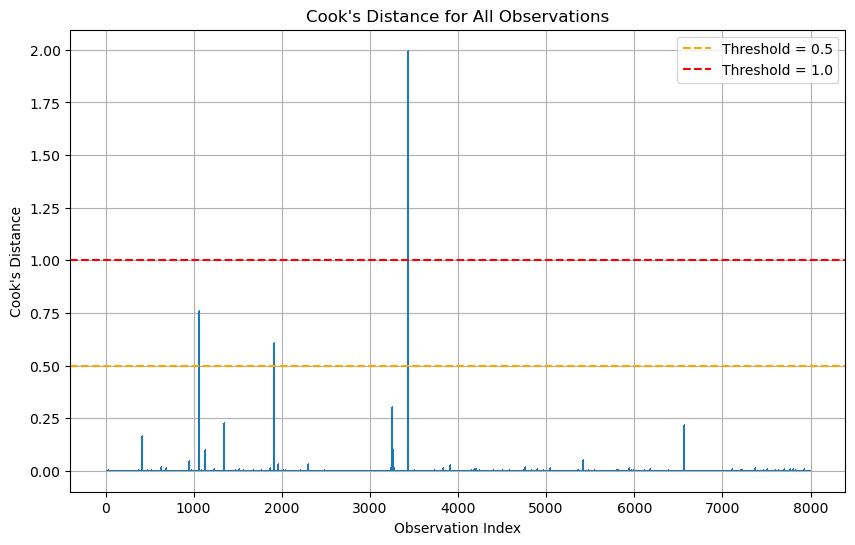

Number of highly influential points (Cook's D > 1): 1
Indices of most influential observations: [3429]


,Sales,Quantity,Discount,Profit,Shipping Delay,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,...,Order Month_September,Order DayOfWeek_Monday,Order DayOfWeek_Saturday,Order DayOfWeek_Sunday,Order DayOfWeek_Thursday,Order DayOfWeek_Tuesday,Order DayOfWeek_Wednesday,Order Year_2015,Order Year_2016,Order Year_2017
3429,17499.95,5,0.0,8399.976,7,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0


In [116]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get influence measures
influence = model.get_influence()

# Step 2: Extract Cook’s Distance and leverage
cooks_d = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag

# Step 3: Plot Cook’s Distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
plt.axhline(y=0.5, color='orange', linestyle='--', label="Threshold = 0.5")
plt.axhline(y=1.0, color='red', linestyle='--', label="Threshold = 1.0")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for All Observations")
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Find most influential observations
influential_points = np.where(cooks_d > 1)[0]
print(f"Number of highly influential points (Cook's D > 1): {len(influential_points)}")
print("Indices of most influential observations:", influential_points[:10])  # preview first 10
df.iloc[influential_points]  # This will show you the full rows


Continuous predictors being tested: ['Sales', 'Quantity', 'Discount', 'Shipping Delay']


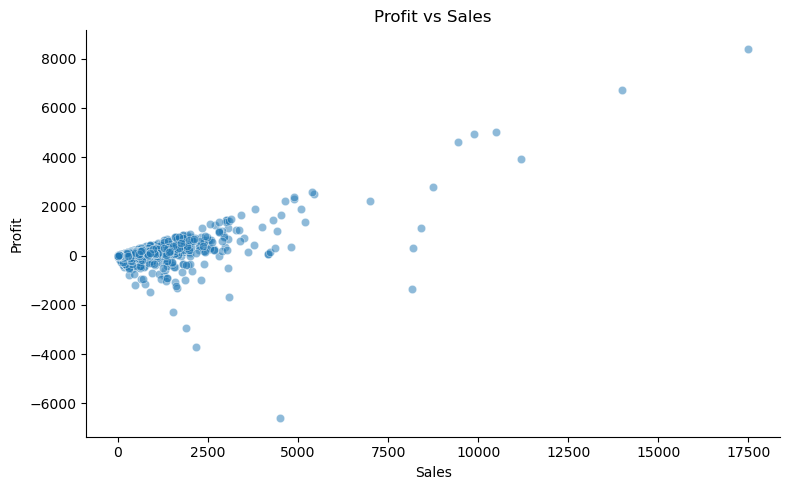

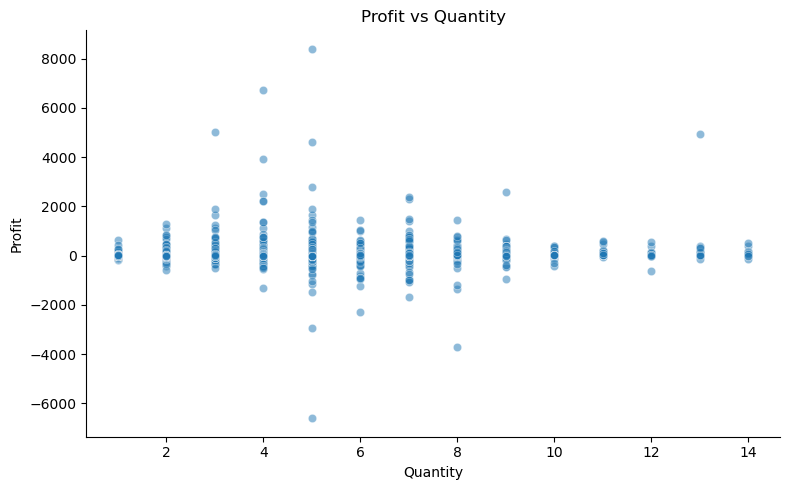

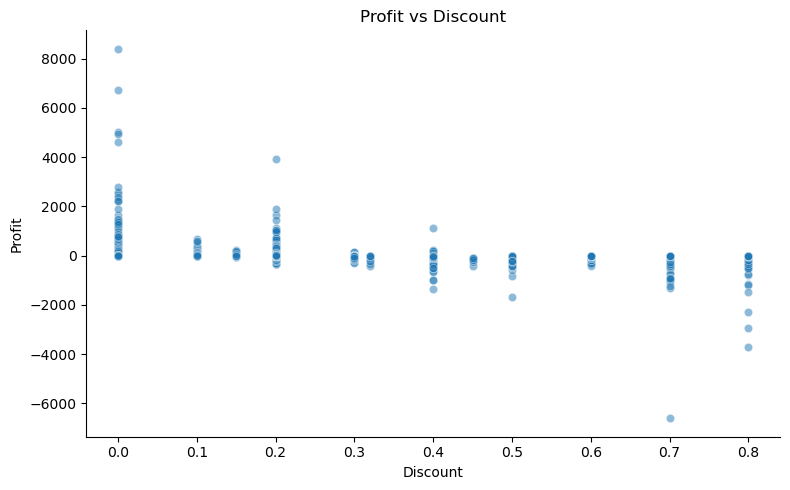

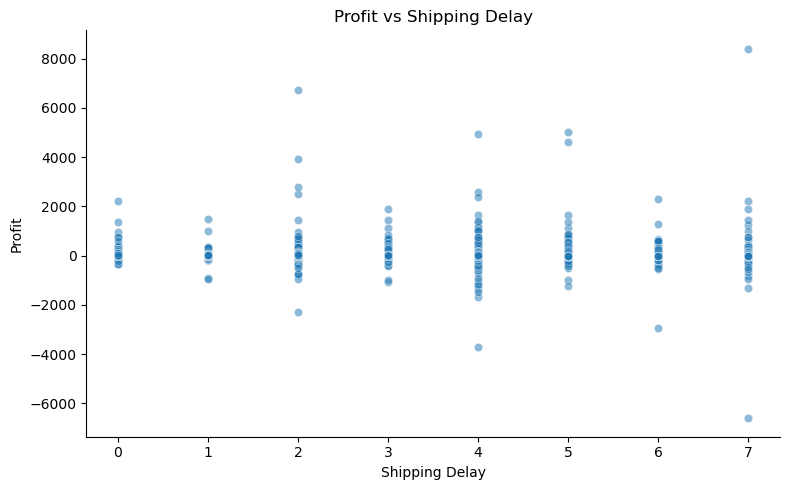

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define target variable
target = 'Profit'

# Identify numeric columns (floats and ints)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Filter for continuous predictors (exclude target and binary variables)
continuous_cols = [col for col in numeric_cols if col != target and df[col].nunique() > 2]

print("Continuous predictors being tested:", continuous_cols)

# Generate scatter plots (no smoothing line)
for col in continuous_cols:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=col, y=target, data=df, alpha=0.5)

    # Clean formatting
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(False)
    plt.title(f'Profit vs {col}')
    plt.xlabel(col)
    plt.ylabel('Profit')
    plt.tight_layout()
    plt.show()


In [118]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import plot_fit
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats import norm

# Re-split into X and y
X = df.drop(columns=['Profit'])
X = sm.add_constant(X)
y = df['Profit']

# Refit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:04:28   Log-Likelihood:                -52710.
No. Observations:                7995   AIC:                         1.055e+05
Df Residuals:                    7960   BIC:                         1.057e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

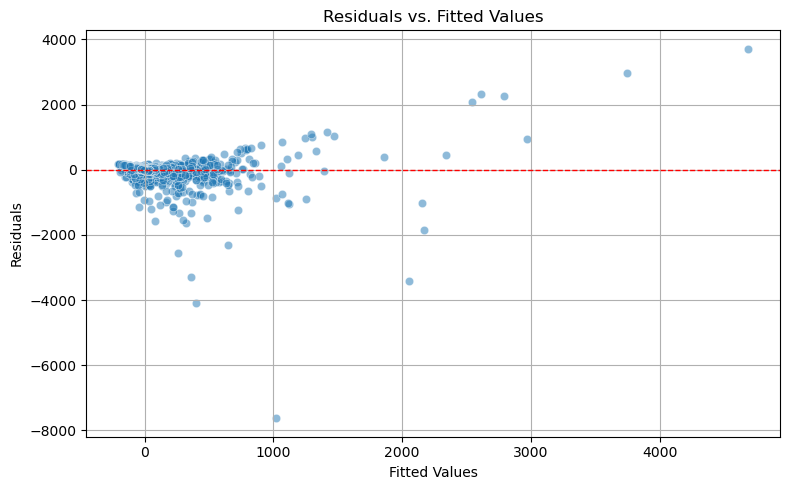

In [119]:
# --------------------------------------
# 1. Residuals vs Fitted Plot
# --------------------------------------
fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

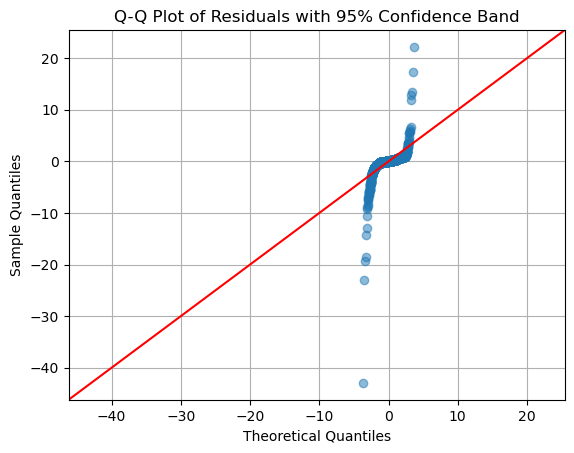

In [120]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Standardized residuals
residuals = model.get_influence().resid_studentized_internal

# Q-Q plot with 95% simulated confidence bands
fig = sm.graphics.qqplot(residuals, line='45', alpha=0.5, fit=True)
plt.title("Q-Q Plot of Residuals with 95% Confidence Band")
plt.grid(True)
plt.show()


In [121]:
from statsmodels.stats.contrast import ContrastResults

# Define your groups
groups_to_test = {
    'Order Month': [col for col in X.columns if "Order Month_" in col],
    'Order DayOfWeek': [col for col in X.columns if "Order DayOfWeek_" in col],
    'Order Year': [col for col in X.columns if "Order Year_" in col],
    'Ship Mode': [col for col in X.columns if "Ship Mode_" in col],
    'Segment': [col for col in X.columns if "Segment_" in col],
    'Region': [col for col in X.columns if "Region_" in col],
    'Category': [col for col in X.columns if "Category_" in col]
}

# Run F-test for each group
for group_name, columns in groups_to_test.items():
    hypothesis = ' + '.join(columns) + ' = 0'
    f_test = model.f_test(hypothesis)
    print(f"📊 F-test for group: {group_name}")
    print(f_test)
    print("-" * 60)


📊 F-test for group: Order Month
<F test: F=0.18557832262382262, p=0.6666341716228253, df_denom=7.96e+03, df_num=1>
------------------------------------------------------------
📊 F-test for group: Order DayOfWeek
<F test: F=3.4192313425351557, p=0.06447806328974727, df_denom=7.96e+03, df_num=1>
------------------------------------------------------------
📊 F-test for group: Order Year
<F test: F=2.2380599828676906, p=0.1346894694774519, df_denom=7.96e+03, df_num=1>
------------------------------------------------------------
📊 F-test for group: Ship Mode
<F test: F=0.2785297032579149, p=0.59768123480897, df_denom=7.96e+03, df_num=1>
------------------------------------------------------------
📊 F-test for group: Segment
<F test: F=0.5259442949390235, p=0.46833828936463995, df_denom=7.96e+03, df_num=1>
------------------------------------------------------------
📊 F-test for group: Region
<F test: F=5.936129231914255, p=0.014855335039255258, df_denom=7.96e+03, df_num=1>
-----------------

In [122]:
# List of patterns to drop
drop_prefixes = ['Order Month_', 'Order Year_', 'Ship Mode_', 'Segment_']

# Optional: include 'Order DayOfWeek_' if you decide to drop that too
# drop_prefixes.append('Order DayOfWeek_')

# Identify columns to drop
cols_to_drop = [col for col in X.columns if any(col.startswith(prefix) for prefix in drop_prefixes)]

# Drop from your dataset
X_reduced = X.drop(columns=cols_to_drop)

print(f"✅ Dropped {len(cols_to_drop)} columns: {cols_to_drop}")


✅ Dropped 19 columns: ['Ship Mode_Same Day', 'Ship Mode_Second Class', 'Ship Mode_Standard Class', 'Segment_Corporate', 'Segment_Home Office', 'Order Month_August', 'Order Month_December', 'Order Month_February', 'Order Month_January', 'Order Month_July', 'Order Month_June', 'Order Month_March', 'Order Month_May', 'Order Month_November', 'Order Month_October', 'Order Month_September', 'Order Year_2015', 'Order Year_2016', 'Order Year_2017']


In [123]:
import statsmodels.api as sm

model_reduced = sm.OLS(y, X_reduced).fit()
print(model_reduced.summary())


                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     429.0
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:04:29   Log-Likelihood:                -52717.
No. Observations:                7995   AIC:                         1.055e+05
Df Residuals:                    7979   BIC:                         1.056e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [124]:
# Generate meaningful interaction terms for modeling

# Sales × Region
df['Sales_x_Region_East'] = df['Sales'] * df['Region_East']
df['Sales_x_Region_South'] = df['Sales'] * df['Region_South']
df['Sales_x_Region_West'] = df['Sales'] * df['Region_West']

# Discount × Category
df['Discount_x_Category_OfficeSup'] = df['Discount'] * df['Category_Office Supplies']
df['Discount_x_Category_Tech'] = df['Discount'] * df['Category_Technology']

# Quantity × Category
df['Quantity_x_Category_OfficeSup'] = df['Quantity'] * df['Category_Office Supplies']
df['Quantity_x_Category_Tech'] = df['Quantity'] * df['Category_Technology']

# Discount × Sales
df['Sales_x_Discount'] = df['Sales'] * df['Discount']

# Discount × Region
df['Discount_x_Region_East'] = df['Discount'] * df['Region_East']
df['Discount_x_Region_South'] = df['Discount'] * df['Region_South']
df['Discount_x_Region_West'] = df['Discount'] * df['Region_West']


In [125]:
import statsmodels.api as sm

# Define target
y = df['Profit']

# Define features (include original key predictors and the interaction terms)
features = [
    'Sales', 'Quantity', 'Discount', 'Shipping Delay',
    'Region_East', 'Region_South', 'Region_West',
    'Category_Office Supplies', 'Category_Technology',
    'Order DayOfWeek_Monday', 'Order DayOfWeek_Tuesday', 'Order DayOfWeek_Wednesday',
    'Order DayOfWeek_Thursday', 'Order DayOfWeek_Saturday', 'Order DayOfWeek_Sunday',

    # Interaction terms
    'Sales_x_Region_East', 'Sales_x_Region_South', 'Sales_x_Region_West',
    'Discount_x_Category_OfficeSup', 'Discount_x_Category_Tech',
    'Quantity_x_Category_OfficeSup', 'Quantity_x_Category_Tech',
    'Sales_x_Discount',
    'Discount_x_Region_East', 'Discount_x_Region_South', 'Discount_x_Region_West'
]

# Subset X and add constant
X = df[features]
X = sm.add_constant(X)

# Fit the model
model_interaction = sm.OLS(y, X).fit()

# Summary
print(model_interaction.summary())


                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     1155.
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:04:29   Log-Likelihood:                -48837.
No. Observations:                7995   AIC:                         9.773e+04
Df Residuals:                    7968   BIC:                         9.792e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [126]:
# Refined list of significant predictors
significant_features = [
    'Sales', 'Quantity',
    'Region_South',
    'Order DayOfWeek_Monday', 'Order DayOfWeek_Tuesday',
    
    # Interaction terms
    'Sales_x_Region_East', 'Sales_x_Region_South', 'Sales_x_Region_West',
    'Discount_x_Category_OfficeSup',
    'Quantity_x_Category_OfficeSup', 'Quantity_x_Category_Tech',
    'Sales_x_Discount',
    'Discount_x_Region_East', 'Discount_x_Region_South', 'Discount_x_Region_West'
]

# Prepare data again
X_clean = df[significant_features]
X_clean = sm.add_constant(X_clean)
y = df['Profit']

# Fit cleaned model
model_clean = sm.OLS(y, X_clean).fit()
print(model_clean.summary())


                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     2000.
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:04:29   Log-Likelihood:                -48844.
No. Observations:                7995   AIC:                         9.772e+04
Df Residuals:                    7979   BIC:                         9.783e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

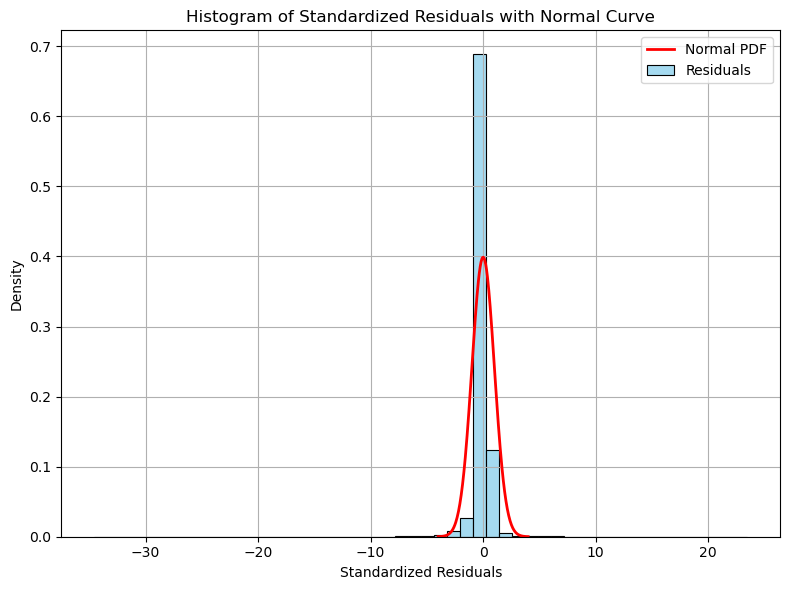

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Use your model residuals
residuals = model_clean.resid

# Standardize the residuals (optional, but helps when comparing to a normal curve)
standardized_resid = (residuals - residuals.mean()) / residuals.std()

# Plot
plt.figure(figsize=(8, 6))
sns.histplot(standardized_resid, bins=50, kde=False, stat='density', color='skyblue', label='Residuals')

# Plot normal distribution curve
x = np.linspace(-4, 4, 200)
plt.plot(x, stats.norm.pdf(x), color='red', label='Normal PDF', linewidth=2)

plt.title('Histogram of Standardized Residuals with Normal Curve')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [128]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
if p < 0.05:
    print("Residuals are not normally distributed. (p-value =", round(p, 4), ")")
else:
    print("Residuals are normally distributed. (p-value =", round(p, 4), ")")

Residuals are not normally distributed. (p-value = 0.0 )


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7995.
  res = hypotest_fun_out(*samples, **kwds)


In [129]:
from scipy.stats import kstest

stat, p = kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
if p < 0.05:
    print("Residuals significantly deviate from normal distribution. (p-value =", round(p, 4), ")")
else:
    print("Residuals follow normal distribution. (p-value =", round(p, 4), ")")

Residuals significantly deviate from normal distribution. (p-value = 0.0 )


In [130]:
# Save original model summary
original_summary = model_clean.summary()
original_r2 = model_clean.rsquared
original_aic = model_clean.aic

In [131]:
from scipy.stats.mstats import winsorize

# Winsorize the target variable (Profit) to handle extreme outliers
df['Profit_winsorized'] = winsorize(df['Profit'], limits=[0.05, 0.05])

# Define the new target variable
y_winsorized = df['Profit_winsorized']

# Re-fit the model using the winsorized target
model_winsorized = sm.OLS(y_winsorized, X_clean).fit()

# Save winsorized model summary
winsorized_summary = model_winsorized.summary()
winsorized_r2 = model_winsorized.rsquared
winsorized_aic = model_winsorized.aic


In [132]:
print("🔹 Original Model Summary:")
print(original_summary)

print("\n🔹 Winsorized Model Summary:")
print(winsorized_summary)

# Compare R-squared and AIC
print("\n📊 Model Performance Comparison:")
print(f"Original R-squared: {round(original_r2, 4)} | Winsorized R-squared: {round(winsorized_r2, 4)}")
print(f"Original AIC: {round(original_aic, 2)} | Winsorized AIC: {round(winsorized_aic, 2)}")

🔹 Original Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     2000.
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:04:29   Log-Likelihood:                -48844.
No. Observations:                7995   AIC:                         9.772e+04
Df Residuals:                    7979   BIC:                         9.783e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

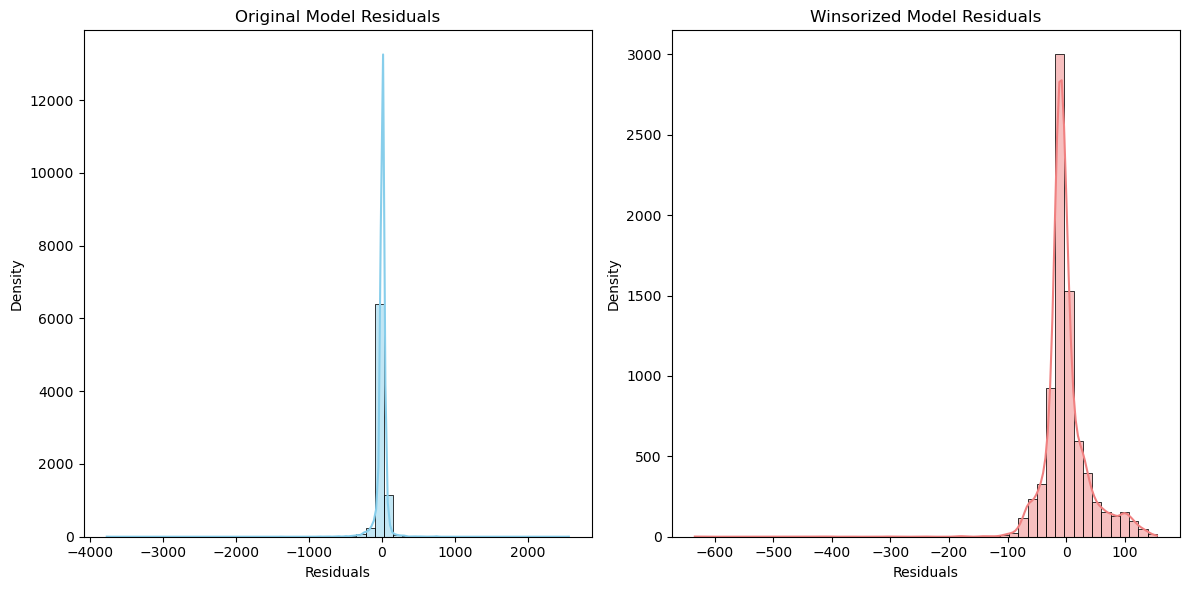

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot original residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(model_clean.resid, bins=50, kde=True, color='skyblue')
plt.title('Original Model Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')

# Plot winsorized residuals
plt.subplot(1, 2, 2)
sns.histplot(model_winsorized.resid, bins=50, kde=True, color='lightcoral')
plt.title('Winsorized Model Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [134]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 🎯 Actual vs. Predicted values
y_actual = y  # assuming y = df['Profit']
y_pred = model_clean.predict(X_clean)

# 🧮 Compute RMSE
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"RMSE of the model: {rmse:.2f}")


RMSE of the model: 108.90


In [135]:
from sklearn.model_selection import train_test_split

# Generate all features (original + interactions)
# ... [your existing code to create features] ...

# Define features and target
y = df['Profit']
X = df[features]

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [136]:
# Add constant to train/test data
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit interaction model on training data
model_train = sm.OLS(y_train, X_train_const).fit()

# Automatically select significant features (p < 0.05)
significant_features = model_train.pvalues[model_train.pvalues < 0.05].index.tolist()
significant_features = [f for f in significant_features if f != 'const']  # exclude constant if needed

# Subset train/test data to significant features
X_train_clean = X_train_const[significant_features]
X_test_clean = X_test_const[significant_features]

# Refit model on cleaned training data
model_clean_train = sm.OLS(y_train, X_train_clean).fit()

In [137]:
# Predictions
y_train_pred = model_clean_train.predict(X_train_clean)
y_test_pred = model_clean_train.predict(X_test_clean)

# RMSE calculations
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"In-sample RMSE: {rmse_train:.2f}")
print(f"Out-of-sample RMSE: {rmse_test:.2f}")

In-sample RMSE: 111.37
Out-of-sample RMSE: 112.96


In [138]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_idx, val_idx in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Add constant
    X_train_fold_const = sm.add_constant(X_train_fold)
    X_val_fold_const = sm.add_constant(X_val_fold)
    
    # Feature selection on training fold
    model_fold = sm.OLS(y_train_fold, X_train_fold_const).fit()
    sig_features = model_fold.pvalues[model_fold.pvalues < 0.05].index.tolist()
    sig_features = [f for f in sig_features if f != 'const']
    
    if not sig_features:
        continue  # handle edge case
    
    X_train_clean_fold = X_train_fold_const[sig_features]
    X_val_clean_fold = X_val_fold_const[sig_features]
    
    # Refit model
    model_clean_fold = sm.OLS(y_train_fold, X_train_clean_fold).fit()
    
    # Predict validation fold
    y_val_pred = model_clean_fold.predict(X_val_clean_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    rmse_scores.append(rmse)

print(f"Cross-validated RMSE: {np.mean(rmse_scores):.2f}")

Cross-validated RMSE: 120.17


In [181]:
baseline_pred = np.mean(y)  # Predict mean for all instances
baseline_rmse = np.sqrt(mean_squared_error(y, np.full_like(y, baseline_pred)))
print(f"Baseline RMSE: {baseline_rmse:.2f}")

Baseline RMSE: 237.59


In [189]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import statsmodels.api as sm

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
mae_scores = []  # List to store MAE values

for train_idx, val_idx in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Add constant
    X_train_fold_const = sm.add_constant(X_train_fold)
    X_val_fold_const = sm.add_constant(X_val_fold)
    
    # Feature selection on training fold
    model_fold = sm.OLS(y_train_fold, X_train_fold_const).fit()
    sig_features = model_fold.pvalues[model_fold.pvalues < 0.05].index.tolist()
    sig_features = [f for f in sig_features if f != 'const']
    
    if not sig_features:
        continue  # handle edge case
    
    X_train_clean_fold = X_train_fold_const[sig_features]
    X_val_clean_fold = X_val_fold_const[sig_features]
    
    # Refit model
    model_clean_fold = sm.OLS(y_train_fold, X_train_clean_fold).fit()
    
    # Predict validation fold
    y_val_pred = model_clean_fold.predict(X_val_clean_fold)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    rmse_scores.append(rmse)
    
    # Calculate MAE
    mae = mean_absolute_error(y_val_fold, y_val_pred)
    mae_scores.append(mae)

print(f"Cross-validated RMSE: {np.mean(rmse_scores):.2f}")
print(f"Cross-validated MAE: {np.mean(mae_scores):.2f}")

Cross-validated RMSE: 120.17
Cross-validated MAE: 37.27


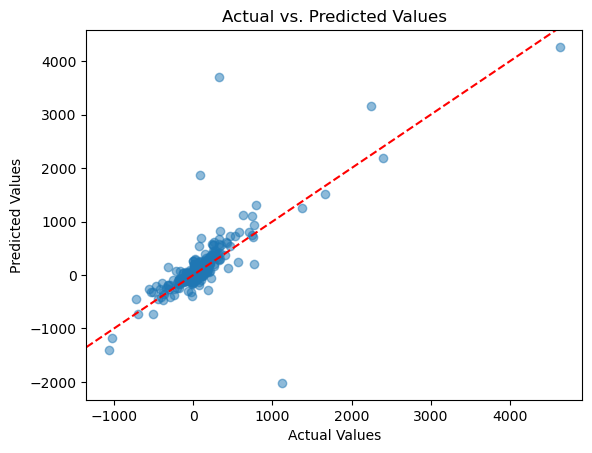

In [183]:
import matplotlib.pyplot as plt

plt.scatter(y_val_fold, y_val_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.show()

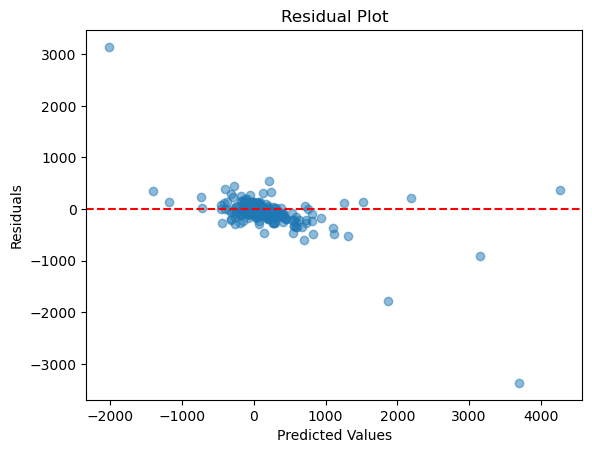

In [185]:
residuals = y_val_fold - y_val_pred

plt.scatter(y_val_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

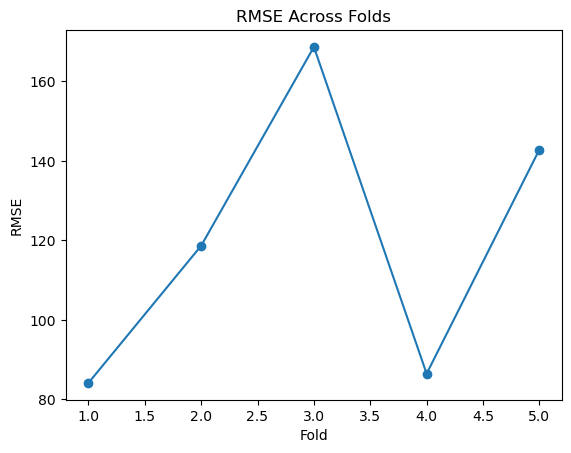

In [187]:
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o')
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("RMSE Across Folds")
plt.show()

In [123]:
from sklearn.model_selection import train_test_split

# Generate all features (original + interactions)
# ... [your existing code to create features] ...

# Define features and target
y = df['Profit']
X = df[features]

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
# Add constant to train/test data
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Fit interaction model on training data
model_train = sm.OLS(y_train, X_train_const).fit()

# Automatically select significant features (p < 0.05)
significant_features = model_train.pvalues[model_train.pvalues < 0.05].index.tolist()
significant_features = [f for f in significant_features if f != 'const']  # exclude constant if needed

# Subset train/test data to significant features
X_train_clean = X_train_const[significant_features]
X_test_clean = X_test_const[significant_features]

# Refit model on cleaned training data
model_clean_train = sm.OLS(y_train, X_train_clean).fit()

In [127]:
# Predictions
y_train_pred = model_clean_train.predict(X_train_clean)
y_test_pred = model_clean_train.predict(X_test_clean)

# RMSE calculations
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"In-sample RMSE: {rmse_train:.2f}")
print(f"Out-of-sample RMSE: {rmse_test:.2f}")

In-sample RMSE: 114.49
Out-of-sample RMSE: 84.15


In [129]:
import numpy as np
from numpy.linalg import cond

# Remove constant before computing
condition_number = cond(X_clean.drop(columns='const'))
print(f"Condition Number: {condition_number:.2f}")


Condition Number: 8490.93


In [131]:
# 📦 Log-transform the dependent variable
import numpy as np
df['Log_Profit'] = np.log(df['Profit'] + abs(df['Profit'].min()) + 1)
  # log(1 + Profit) for stability

# 🎯 Set y as the log-transformed target
y_log = df['Log_Profit']

# 📊 Fit OLS model using the same cleaned predictor set
import statsmodels.api as sm

X_log = sm.add_constant(X_clean)  # Add intercept
model_log = sm.OLS(y_log, X_log).fit()

# 📝 Display results
print(model_log.summary())


                            OLS Regression Results                            
Dep. Variable:             Log_Profit   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     204.6
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        22:26:35   Log-Likelihood:                 7909.2
No. Observations:                7995   AIC:                        -1.579e+04
Df Residuals:                    7982   BIC:                        -1.570e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [133]:
from scipy.stats import jarque_bera

print("Original model JB test:", jarque_bera(resid_original))
print("Log model JB test:", jarque_bera(resid_log))


NameError: name 'resid_original' is not defined

In [136]:
# import itertools
# import statsmodels.api as sm
# import pandas as pd

# # Assume X_reduced and y are already defined from your earlier cells.
# # If X_reduced includes a constant column, remove it from the candidate predictors.
# features = X_reduced.columns.tolist()
# if 'const' in features:
#     features.remove('const')

# # Prepare a list to collect results for each subset.
# results = []

# # Loop over all possible combinations of predictors.
# # WARNING: This exhaustive search can be computationally heavy if there are many predictors.
# for k in range(1, len(features) + 1):
#     for combo in itertools.combinations(features, k):
#         # Create a temporary dataset with the selected predictors plus the constant.
#         X_subset = X_reduced[list(combo) + ['const']]
#         model = sm.OLS(y, X_subset).fit()
#         results.append({
#             'features': combo,
#             'num_features': k,
#             'RSS': ((model.predict(X_subset) - y) ** 2).sum(),
#             'R2': model.rsquared,
#             'Adj_R2': model.rsquared_adj,
#             'AIC': model.aic,
#             'BIC': model.bic
#         })

# # Convert the list of results to a DataFrame for easier viewing.
# results_df = pd.DataFrame(results)

# # Sort by a criterion of interest. For example, lowest AIC:
# best_aic = results_df.sort_values(by='AIC').reset_index(drop=True)
# print("Top 5 models sorted by AIC:")
# print(best_aic.head(5))

# # Alternatively, you can sort by adjusted R-squared (highest first):
# best_adj_r2 = results_df.sort_values(by='Adj_R2', ascending=False).reset_index(drop=True)
# print("\nTop 5 models sorted by Adjusted R²:")
# print(best_adj_r2.head(5))


In [138]:
# # Choose the continuous variable for interactions.
# continuous_var = 'Sales'  # You can change this to 'Quantity' or 'Discount' as needed.

# # Identify dummy columns for your categorical variables.
# region_cols = [col for col in df.columns if col.startswith('Region_')]
# category_cols = [col for col in df.columns if col.startswith('Category_')]
# day_cols = [col for col in df.columns if col.startswith('Order DayOfWeek_')]

# # Create interactions between the continuous variable and Region dummies.
# for col in region_cols:
#     new_col = f'{continuous_var}_{col}_interaction'
#     df[new_col] = df[continuous_var] * df[col]

# # Create interactions between the continuous variable and Category dummies.
# for col in category_cols:
#     new_col = f'{continuous_var}_{col}_interaction'
#     df[new_col] = df[continuous_var] * df[col]

# # Create interactions between the continuous variable and Order DayOfWeek dummies.
# for col in day_cols:
#     new_col = f'{continuous_var}_{col}_interaction'
#     df[new_col] = df[continuous_var] * df[col]

# # Verify the new interaction columns.
# interaction_cols = [col for col in df.columns if f'{continuous_var}_' in col and 'interaction' in col]
# print("New interaction columns with", continuous_var, ":")
# print(interaction_cols)


In [140]:
# import statsmodels.api as sm

# # Define the continuous variable and the list of dummy columns (update as needed)
# continuous_var = 'Sales'
# region_cols = [col for col in df.columns if col.startswith('Region_')]
# category_cols = [col for col in df.columns if col.startswith('Category_')]
# day_cols = [col for col in df.columns if col.startswith('Order DayOfWeek_')]

# # Identify the interaction columns we created with the continuous variable
# interaction_cols = [col for col in df.columns if f'{continuous_var}_' in col and 'interaction' in col]

# # Build the predictor matrix: include the continuous variable, the dummy variables, and the interaction terms
# predictor_cols = [continuous_var] + region_cols + category_cols + day_cols + interaction_cols

# # Create X and y
# X_interaction = df[predictor_cols]
# y = df['Profit']

# # Add a constant to the model
# X_interaction = sm.add_constant(X_interaction)

# # Fit the model
# model_interaction = sm.OLS(y, X_interaction).fit()

# # Display the summary to evaluate coefficients, R², p-values, etc.
# print(model_interaction.summary())
